In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Load dataframe
df = pd.read_csv(
    './de.csv', 
    usecols = ['city', 'lat', 'lng', 'population', 'capital', 'admin_name', 'gdp'])

In [3]:
print(df['gdp'])

0      40105
1      90518
2      79690
3      64771
4      59588
       ...  
117    38925
118    38925
119    50982
120    34610
121    34610
Name: gdp, Length: 122, dtype: int64


In [4]:
RANDOM_STATE = 4          # For reproducibility
FRACTION_CUSTOMERS = 0.5  # Fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 1 # Fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 80    # Fraction of citizens of a city that may order a product  

# List of the 16 regions of germany
REGION_LIST = [
    'Berlin', 'Baden-Württemberg', 'Bavaria', 'Hamburg', 'North Rhine-Westphalia', 'Hesse', 'Saxony', 
    'Bremen', 'Lower Saxony', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Rhineland-Palatinate', 'Thuringia', 'Brandenburg',
    'Saarland', 'Mecklenburg-Western Pomerania']

# Demand is composed of: 
#   1. A fraction of the population
#   2. An error term of uniform distribution
# Note: demand is approximated to the closest int 
# as its physical meaning denies decimals
df['ratio'] = (FRACTION_DEMAND * df['gdp'])/47000

df['demand'] = np.floor(
    df['ratio'] * df.population + np.random.uniform(-10, 10, size=(df.shape[0],)))

# Create the warehouses dataframe:
#   1. Filter the 20 regions of Italy
#   2. Filter capitals as candidate warehouse locations
#   3. Sample a fraction of the original cities
facility_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                loc[df.capital.isin(['admin'])].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)

# Create the customers dataframe:
#   1. Filter the 20 regions of Italy
#   2. Sample a fraction of the original cities
customer_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])


In [5]:
print(df['demand'])

0      305350998.0
1      429513526.0
2      353487347.0
3      273945493.0
4      109895281.0
          ...     
117       472603.0
118       428536.0
119       553474.0
120       311043.0
121       182915.0
Name: demand, Length: 122, dtype: float64


In [6]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
facility_df = add_geocoordinates(facility_df)

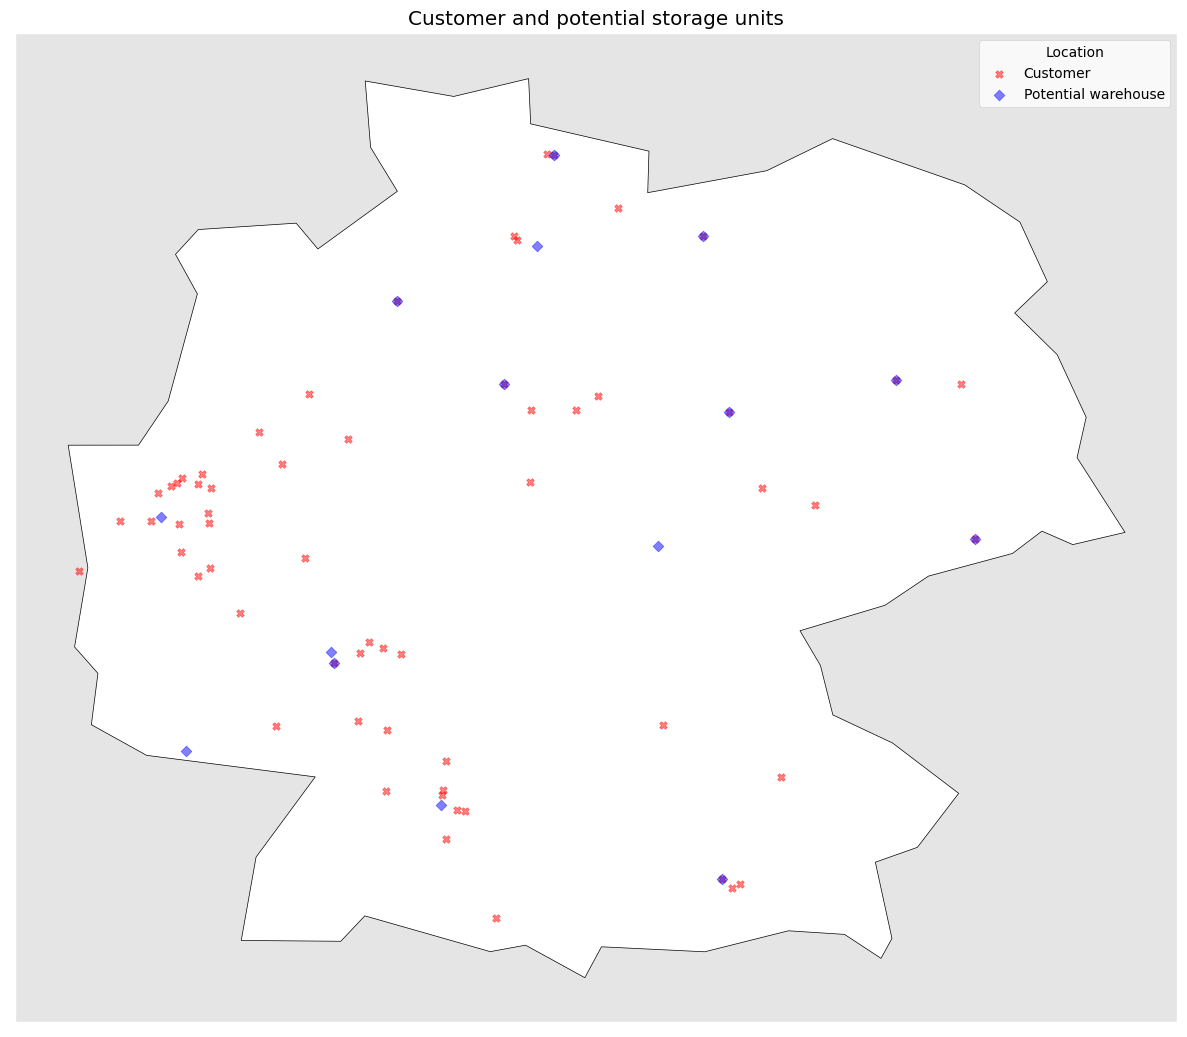

In [7]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Germany
germany = world[world.name == 'Germany']
ax = germany.plot(color='white', edgecolor='black', figsize=(15, 15))

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
facility_df.\
    plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potential warehouse')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customer and potential storage units')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

plt.savefig('Customerwarehouses1.png')

# Show plot
plt.show()

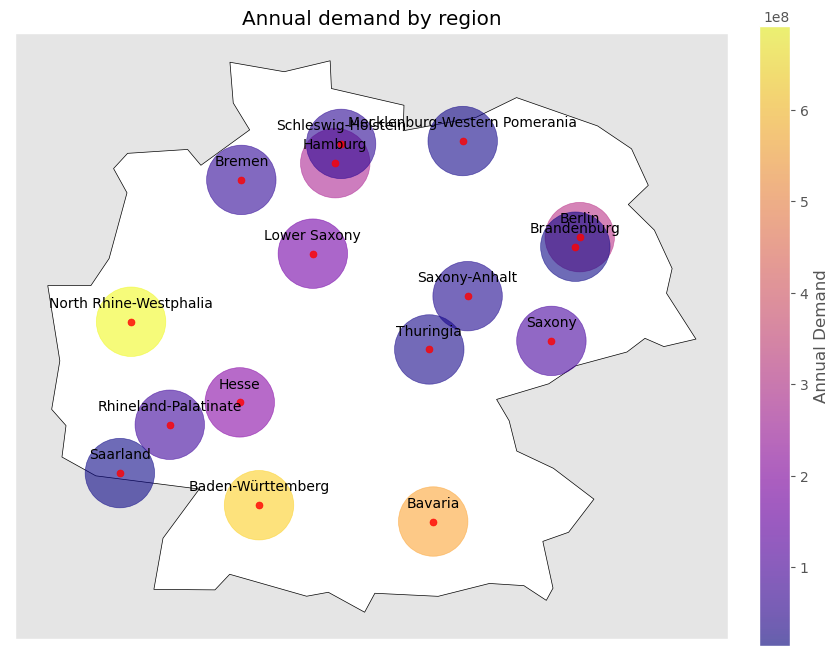

In [8]:
# Prepare region dataframe:
#   1. Filter the 16 regions of germany
#   2. Group by region
#   3. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = df.\
             loc[df.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='plasma', markersize=2500, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.admin_name, xy=(row.lng, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

plt.savefig('annualdemand.png')

# Show plot
plt.show()

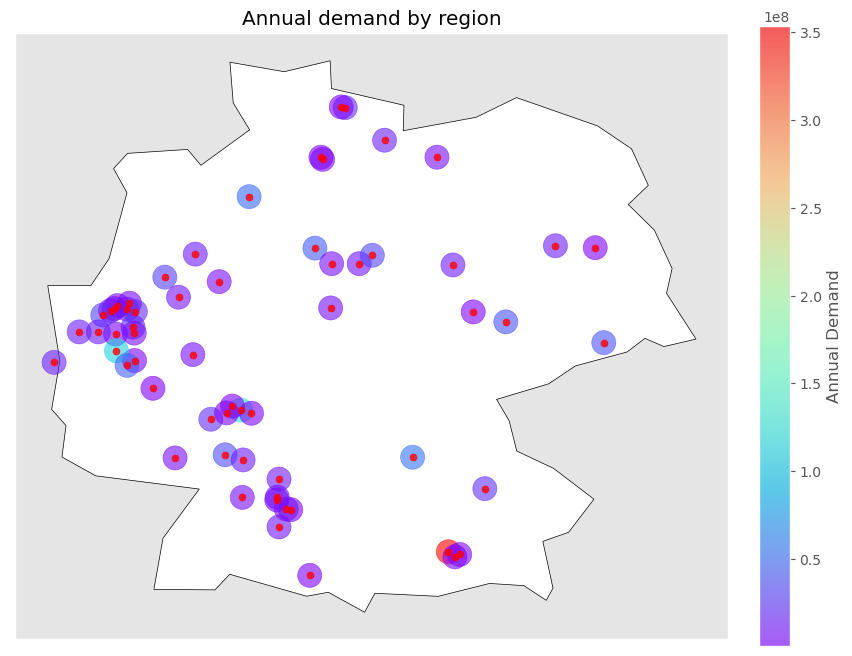

In [9]:
# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
customer_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='rainbow', markersize=300, alpha=0.6)

# Add region 'center' as red dots
customer_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [10]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }


In [22]:
# Assumptions: 
#    1. Each warehouse has an annual cost of 100.000,00 euros: rent, electricity, ...
#    2. Each warehouse can meet 1 times the regional average annual demand
COST_PER_WAREHOUSE = 1_000_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = { warehouse : COST_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

print(annual_supply_dict)
print(annual_cost_dict)

{'Warehouse 1': 597440694.5625, 'Warehouse 2': 597440694.5625, 'Warehouse 3': 597440694.5625, 'Warehouse 4': 597440694.5625, 'Warehouse 5': 597440694.5625, 'Warehouse 6': 597440694.5625, 'Warehouse 7': 597440694.5625, 'Warehouse 8': 597440694.5625, 'Warehouse 9': 597440694.5625, 'Warehouse 10': 597440694.5625, 'Warehouse 11': 597440694.5625, 'Warehouse 12': 597440694.5625, 'Warehouse 13': 597440694.5625, 'Warehouse 14': 597440694.5625, 'Warehouse 15': 597440694.5625}
{'Warehouse 1': 1000000, 'Warehouse 2': 1000000, 'Warehouse 3': 1000000, 'Warehouse 4': 1000000, 'Warehouse 5': 1000000, 'Warehouse 6': 1000000, 'Warehouse 7': 1000000, 'Warehouse 8': 1000000, 'Warehouse 9': 1000000, 'Warehouse 10': 1000000, 'Warehouse 11': 1000000, 'Warehouse 12': 1000000, 'Warehouse 13': 1000000, 'Warehouse 14': 1000000, 'Warehouse 15': 1000000}


In [12]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [13]:
def traveling_cost(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 1.5 * distance_in_km

In [14]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

In [15]:
## Create a new model
model = gp.Model('CFLP')

# Variable: y_j (constraint: it is binary)
created_facility = {}
for j in facility_df['warehouse_id']:
    created_facility[j] = model.addVar(vtype=GRB.BINARY, name=f'Create_facility_{j}')

# Variable: x_ij
served_customer = {}
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        served_customer[(i, j)] = model.addVar(lb=0, name=f'Link_{i}_{j}')

# Objective function
objective = gp.quicksum(annual_cost_dict[j] * created_facility[j] for j in facility_df['warehouse_id']) + \
            gp.quicksum(transport_costs_dict[j][i] * served_customer[(i, j)] for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])
model.setObjective(objective, GRB.MINIMIZE)

# Constraint: the demand must be met
for i in customer_df['customer_id']:
    model.addConstr(gp.quicksum(served_customer[(i, j)] for j in facility_df['warehouse_id']) == demand_dict[i])

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    model.addConstr(gp.quicksum(served_customer[(i, j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j])

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        model.addConstr(served_customer[(i, j)] <= demand_dict[i] * created_facility[j])

# Optimize the model
model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 991 rows, 930 columns and 3675 nonzeros
Model fingerprint: 0x730203e3
Variable types: 915 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+08]
  Objective range  [6e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+05, 4e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 6.693461e+11
Presolve time: 0.00s
Presolved: 991 rows, 930 columns, 3675 nonzeros
Variable types: 915 continuous, 15 integer (15 binary)

Root relaxation: objective 7.038423e+10, 14 iterations, 0.00 seconds (0.00 work units)

    Node

In [16]:

# Create dataframe column to store whether to build the warehouse or not
facility_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in facility_df['warehouse_id']:
    if created_facility[i].X == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 1
Build site at:  Warehouse 2
Build site at:  Warehouse 3
Build site at:  Warehouse 4
Build site at:  Warehouse 5
Build site at:  Warehouse 6
Build site at:  Warehouse 8
Build site at:  Warehouse 9
Build site at:  Warehouse 10
Build site at:  Warehouse 11
Build site at:  Warehouse 12
Build site at:  Warehouse 13
Build site at:  Warehouse 14
Build site at:  Warehouse 15


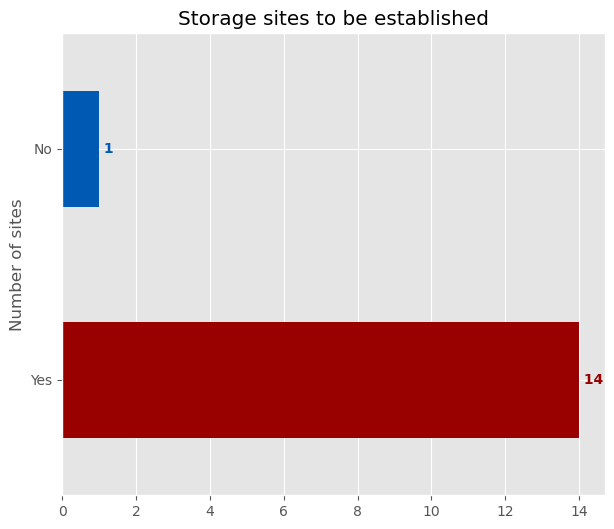

In [17]:
colors = ['#990000', '#0059b3']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Storage sites to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')

plt.savefig('Storagetobeestablished.png')


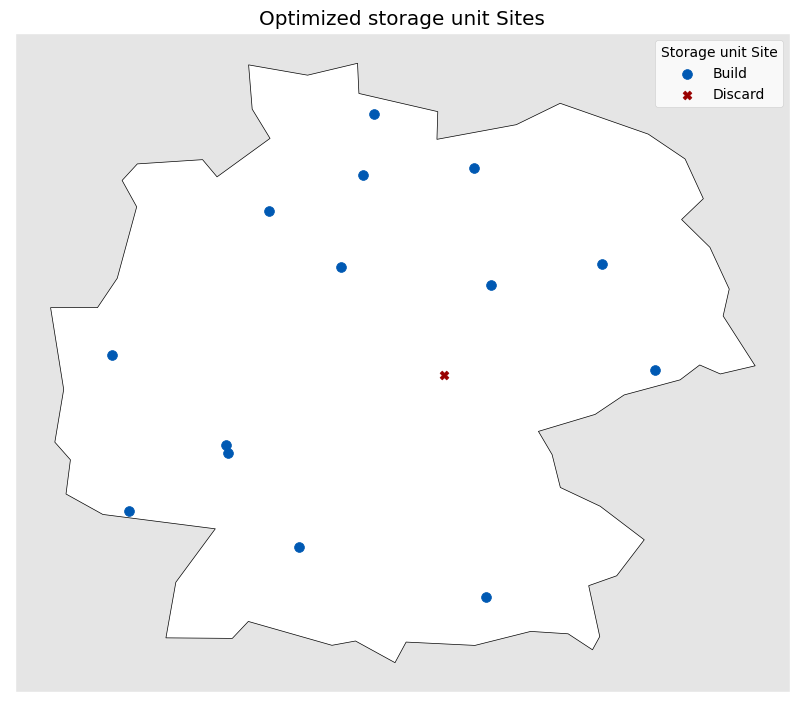

In [18]:
# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
facility_df.\
    loc[facility_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='o', c='#0059b3', markersize=50, label='Build')

# Plot sites to discard
facility_df.\
    loc[facility_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='#990000', markersize=40, label='Discard')

# Add title
plt.title('Optimized storage unit Sites')

# Add legend
plt.legend(title='Storage unit Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

plt.savefig('Storageunitotpimised.png')


# Show plot
plt.show()

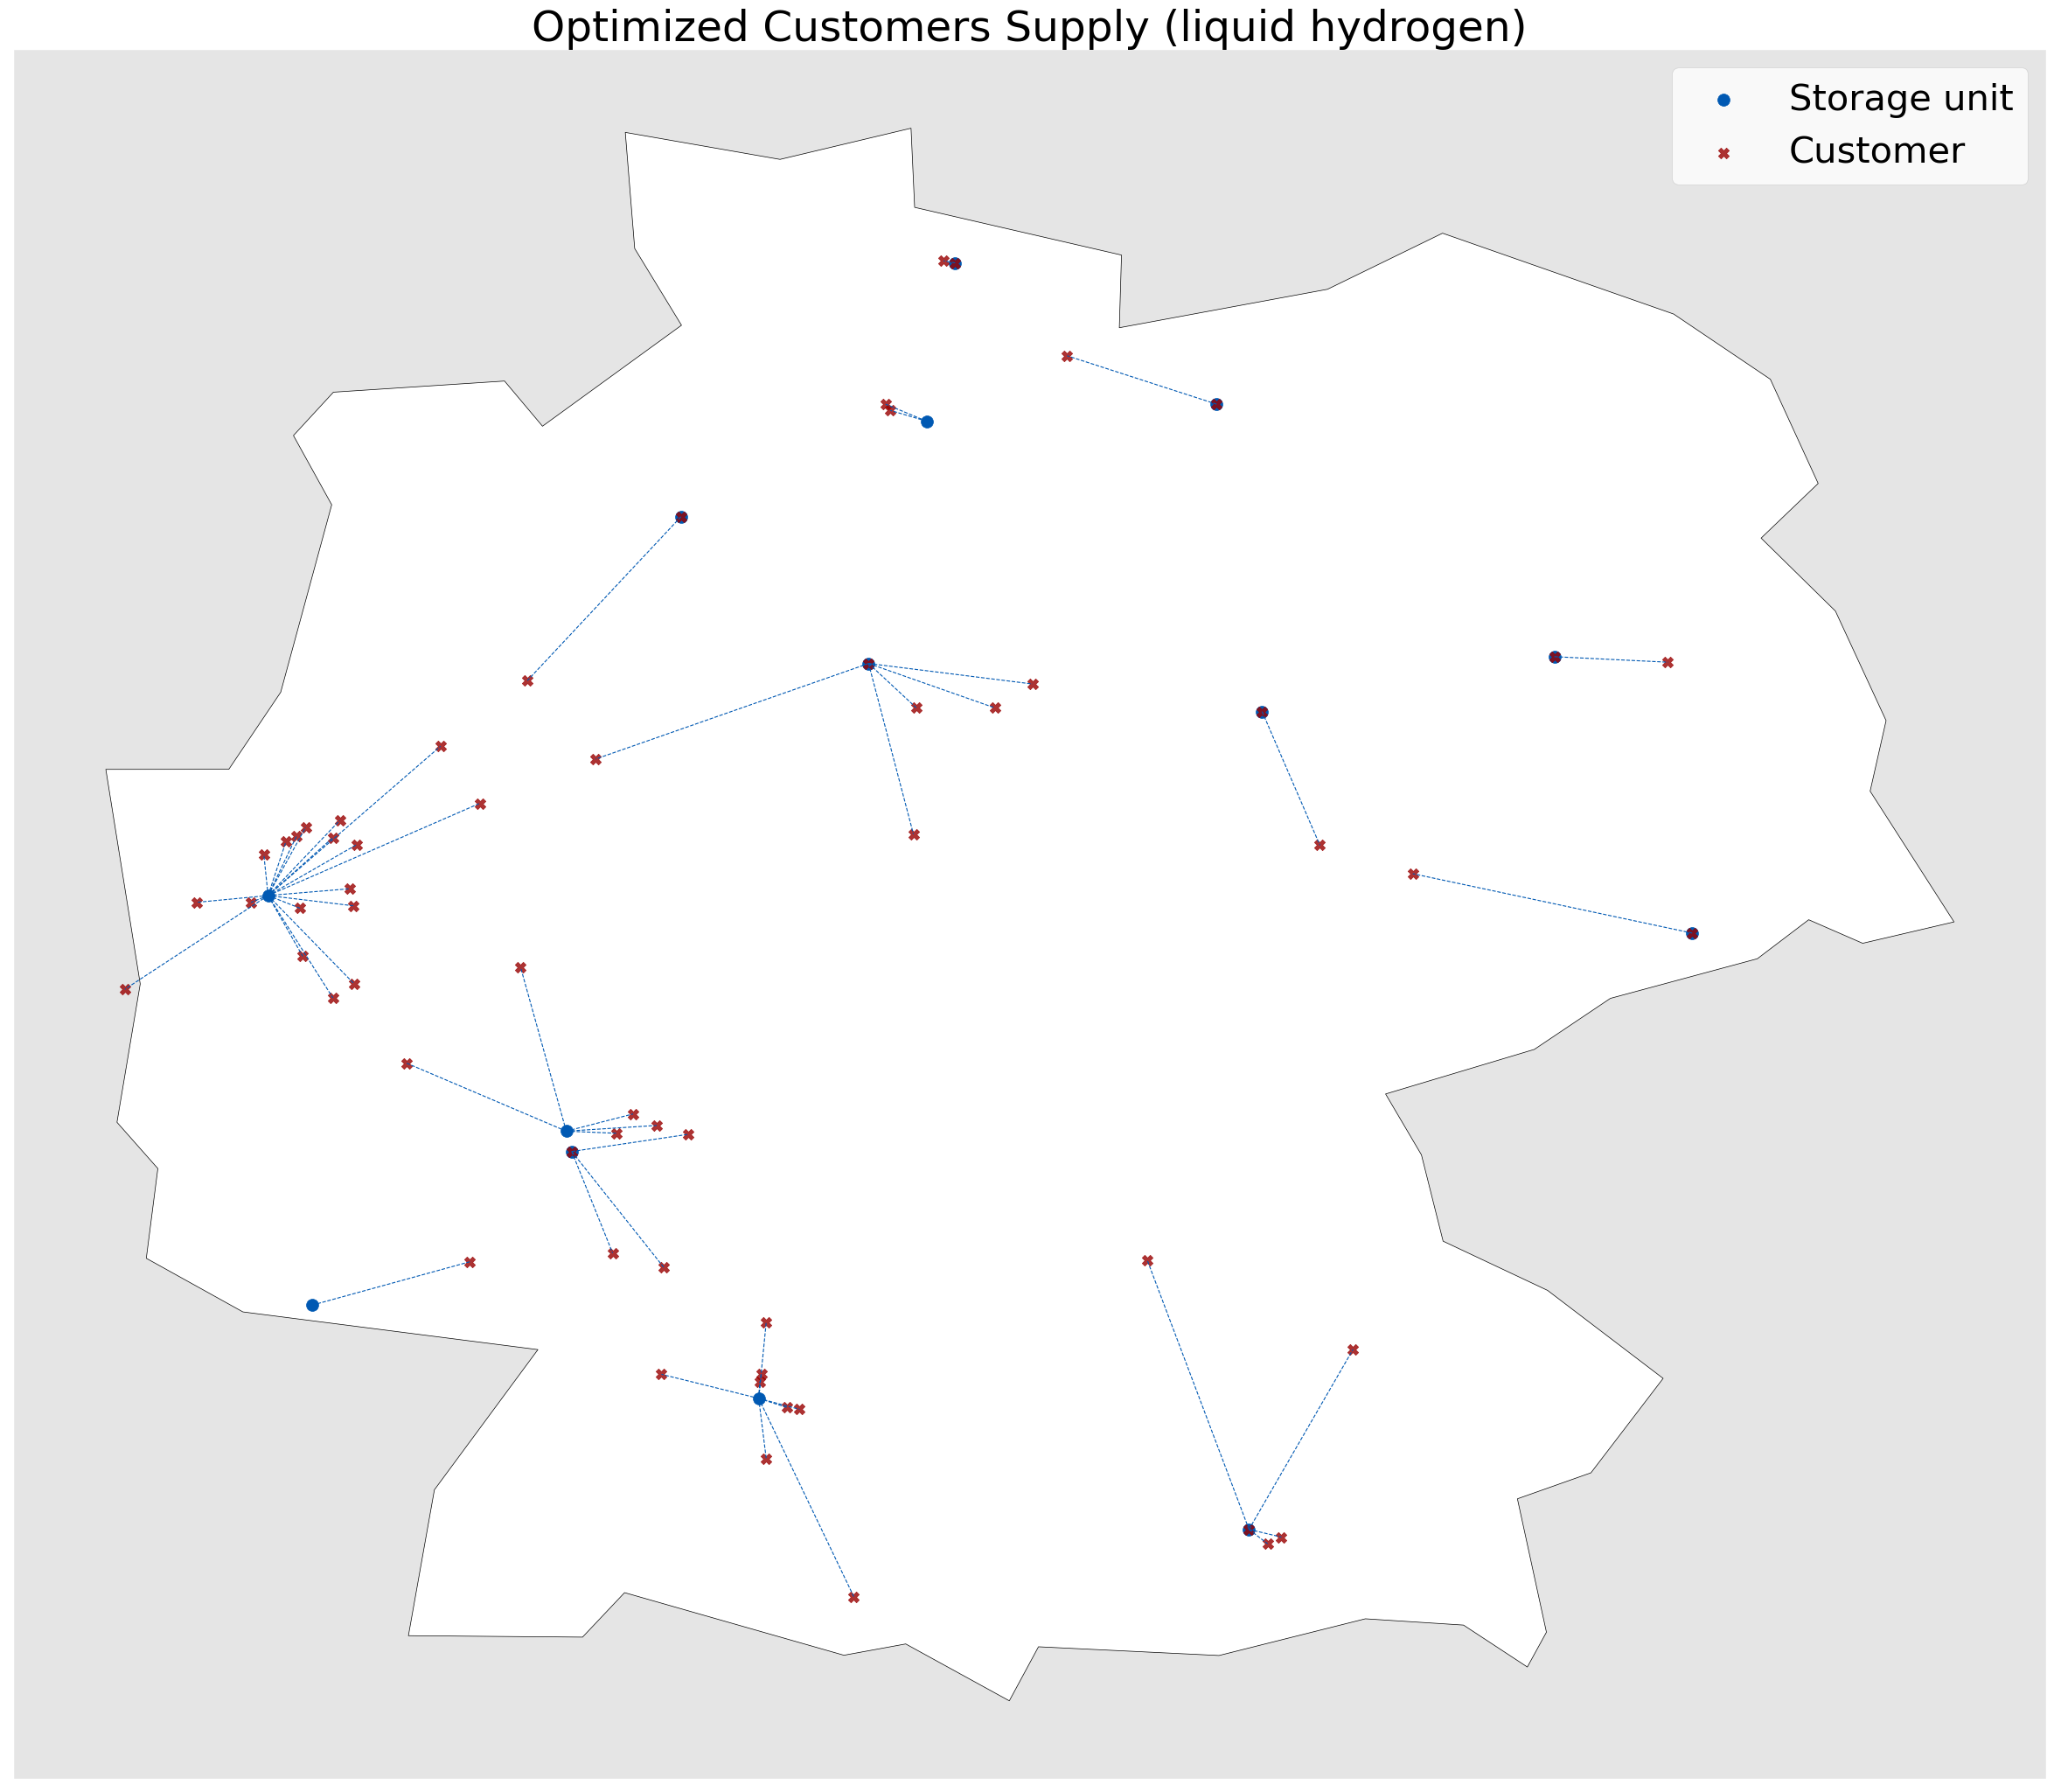

In [19]:
def get_linked_customers(input_warehouse):
    '''
    Find customer ids that are served by the input warehouse.

    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty 
    linked_customers = []

    # Iterate through the xij decision variable
    for (i, j) in served_customer.keys():
        # Filter the input warehouse and positive variable values
        if j == input_warehouse and served_customer[(i, j)].X > 0:
            # Customer is served by the input warehouse
            linked_customers.append(i)

    return linked_customers


# Warehouses to establish
establish = facility_df.loc[facility_df['build_warehouse'] == 'Yes']

# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish.plot(ax=ax, marker='o', c='#0059b3', markersize=100, label='Storage unit')

# Plot customers
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish['warehouse_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish.loc[establish['warehouse_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish.loc[establish['warehouse_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='#0059b3')

# Add title
plt.title('Optimized Customers Supply (liquid hydrogen)', fontsize=35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

plt.savefig('Storagecustomer.png')


# Show plot
plt.show()list

In [21]:
customer_df.to_csv("customer.csv")
facility_df.to_csv("facility_liquid.csv")